In [1]:
# Import Statements
import numpy as np
import matplotlib.pyplot as plt
from math import log, exp, log10, copysign
from scipy.fft import fft, ifft
import time, sys, os              # and load some utilities
print('Python version', sys.version)

Python version 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


In [2]:
# use higher resolution svg graphics instead of png:
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf')
set_matplotlib_formats('svg')

# adjust plotting style defaults:

# default figure size okay if notebook is zoomed for class presentation:
# plt.rcParams["figure.figsize"] = [6.4, 4.8] # default
plt.rcParams["figure.figsize"] = [8.0, 6.0]
plt.rcParams['font.size'] = 14  # default is about 12.
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['figure.titlesize'] = 'medium'

In [3]:
global n_ghost
n_ghost = 3

In [4]:
def velocity(x_mesh):
  # grad(psi) cross z^ is v, for now return 1
  # psi = y => v = 1*x^
  return np.ones(len(x_mesh))

In [43]:
# Returns a single time step FV method over the entire spatial grid
def finite_vol(omega, v, dx, dt):
  C4 = 1
  viscosity = 0.005
  vplushalf = (1/2)*(v[n_ghost:-n_ghost]+v[n_ghost+1:-n_ghost+1])
  vminushalf = (1/2)*(v[n_ghost-1:-n_ghost-1]+v[n_ghost:-n_ghost])

  omegaplushalf = (7/12)*(omega[n_ghost+1:-n_ghost+1]+omega[n_ghost:-n_ghost]) - (1/12)*(omega[n_ghost-1:-n_ghost-1]+omega[n_ghost+2:-n_ghost+2])
  omegaminushalf = (7/12)*(omega[n_ghost:-n_ghost]+omega[n_ghost-1:-n_ghost-1]) - (1/12)*(omega[n_ghost-2:-n_ghost-2]+omega[n_ghost+1:-n_ghost+1])
  
  Fplushalf = vplushalf*omegaplushalf - (C4*np.abs(vplushalf)*dx/48)*((3/12)*(omega[n_ghost+1:-n_ghost+1]-omega[n_ghost:-n_ghost]) - (1/12)*(omega[n_ghost+2:-n_ghost+2]-omega[n_ghost-1:-n_ghost-1]))
  Fminushalf = vminushalf*omegaminushalf - (C4*np.abs(vminushalf)*dx/48)*((3/12)*(omega[n_ghost:-n_ghost]-omega[n_ghost-1:-n_ghost-1]) - (1/12)*(omega[n_ghost+1:-n_ghost+1]-omega[n_ghost-2:-n_ghost-2]))
  
  second_der = (1/(dx**2))*(omega[n_ghost+1:-n_ghost+1]-2*omega[n_ghost:-n_ghost]+omega[n_ghost-1:-n_ghost-1])

  # CHECK DIMENSIONS
  
  sol = dt*viscosity*second_der - (dt/dx)*(Fplushalf - Fminushalf)
  
  return sol

In [44]:
# Returns 3rd order Runge-Kutta full time advance
def RK3_full_advance(f, omega, v, dx, dt, t_end):
  t = 0.0
  omega0 = np.zeros(len(omega))
  omega1 = np.zeros(len(omega))
  omega2 = np.zeros(len(omega))
  omega_sol = omega
  
  while t <t_end:
    
    omega0 = omega_sol
    omega1[n_ghost:-n_ghost] = omega0[n_ghost:-n_ghost] + finite_vol(omega0, v, dx,dt)
    # B.C.
    for i in range(n_ghost):
      omega1[i] = omega1[-2*n_ghost+i]
      omega1[-n_ghost+i] = omega1[n_ghost+i]

    omega2[n_ghost:-n_ghost] = (3/4)*omega0[n_ghost:-n_ghost] + omega1[n_ghost:-n_ghost]/4 + (1/4)*finite_vol(omega1,v,dx,dt)
    # BC
    for i in range(n_ghost):
      omega2[i] = omega2[-2*n_ghost+i]
      omega2[-n_ghost+i] = omega2[n_ghost+i]

    omega_sol[n_ghost:-n_ghost] = omega0[n_ghost:-n_ghost]/3 + 2*omega2[n_ghost:-n_ghost]/3 + (2/3)*finite_vol(omega2,v,dx,dt)
    # BC
    for i in range(n_ghost):
      omega_sol[i] = omega_sol[-2*n_ghost+i]
      omega_sol[-n_ghost+i] = omega_sol[n_ghost+i]
    t = t+dt
  
  return omega_sol

In [45]:
# space grid
dx = 0.001
x_mesh = np.arange(-1,1+dx,dx)

# Append 3 Ghost cells on either side
x_mesh = np.append(x_mesh, 1+dx)
x_mesh = np.append(x_mesh, 1+2*dx)
x_mesh = np.append(x_mesh, 1+3*dx)
x_mesh = np.insert(x_mesh, 0, -1-dx)
x_mesh = np.insert(x_mesh, 0, -1-2*dx)
x_mesh = np.insert(x_mesh, 0, -1-3*dx)


v=1
cfl = 0.1

# time params
dt = cfl*dx/v
t_end = 2.006

omega_initial = np.zeros(len(x_mesh))
omega_initial = 0.5*np.exp(-np.square(x_mesh-0.5)/0.03)
for i in range (len(omega_initial)):
  if x_mesh[i]<-0.35 and x_mesh[i]>-0.7:
    omega_initial[i] = 0.5

sol = RK3_full_advance(finite_vol, omega_initial, velocity(x_mesh), dx, dt, t_end)

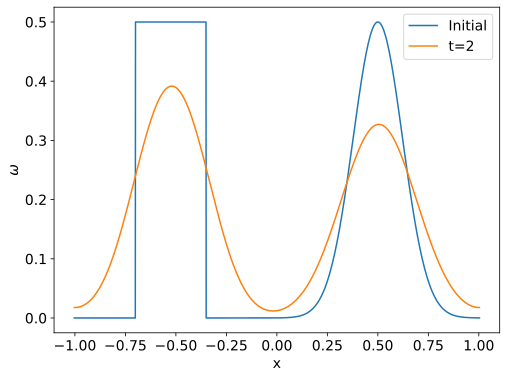

In [47]:
omega_initial = np.zeros(len(x_mesh))
omega_initial = 0.5*np.exp(-np.square(x_mesh-0.5)/0.03)
for i in range (len(omega_initial)):
  if x_mesh[i]<-0.35 and x_mesh[i]>-0.7:
    omega_initial[i] = 0.5


plt.plot(x_mesh, omega_initial, label = "Initial")
plt.plot(x_mesh, sol, label = "t=2")
plt.legend()
plt.xlabel("x")
plt.ylabel("$\omega$")
plt.savefig("1D_new_t=2_nu=0.005_dx=0.001.pdf")
plt.show()